In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import statsmodels.stats.api as sm
import statsmodels.stats.power as sp

plt.rc("figure", figsize=(16, 10))

In [2]:
class Money:
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return "${:.2f}".format(self.value)


class Exchange:
    def __init__(self, name, cost):
        self.name = name
        self.cost = cost

    def sample(self) -> int:
        return self.cost + np.random.normal()


class TimeOfDayEffectWrapper:
    def __init__(self, exchange: Exchange):
        self.exchange = exchange

    def sample(self, tod="afternoon"):
        bias = 2.5 if tod == "morning" else 0.0
        return self.exchange.sample()


asdaq = Exchange(name="ASDAQ", cost=12)
print(Money(asdaq.sample()))

asdaq = TimeOfDayEffectWrapper(asdaq)
print(Money(asdaq.sample("morning")))
print(Money(asdaq.sample("afternoon")))

byse = Exchange(name="BYSE", cost=10)
byse = TimeOfDayEffectWrapper(byse)
print(Money(byse.sample()))

$11.95
$13.56
$11.32
$10.17


In [3]:
print(Money(np.mean([byse.sample() for _ in range(100)])))
print(Money(np.mean([asdaq.sample() for _ in range(100)])))

$10.06
$12.13


In [4]:
def aggregate_measurements(n):
    return np.mean([asdaq.sample() for _ in range(n)])


print(np.std([aggregate_measurements(10) for _ in range(1000)]))
print(np.std([aggregate_measurements(100) for _ in range(1000)]))
print(np.std([aggregate_measurements(1000) for _ in range(1000)]))

0.32598030127200134
0.1020042867238196
0.031182526602051782


In [5]:
sample_size = 10
sample_count = 1000

sample_population = np.array(
    [aggregate_measurements(sample_size) for _ in range(sample_count)]
)
print("Mean: {:.4f}".format(sample_population.mean()))
print("Std Error: {:.4f}".format(st.sem(sample_population)))
print("Std Deviation: {:.4f}".format(sample_population.std()))

Mean: 12.0042
Std Error: 0.0101
Std Deviation: 0.3206


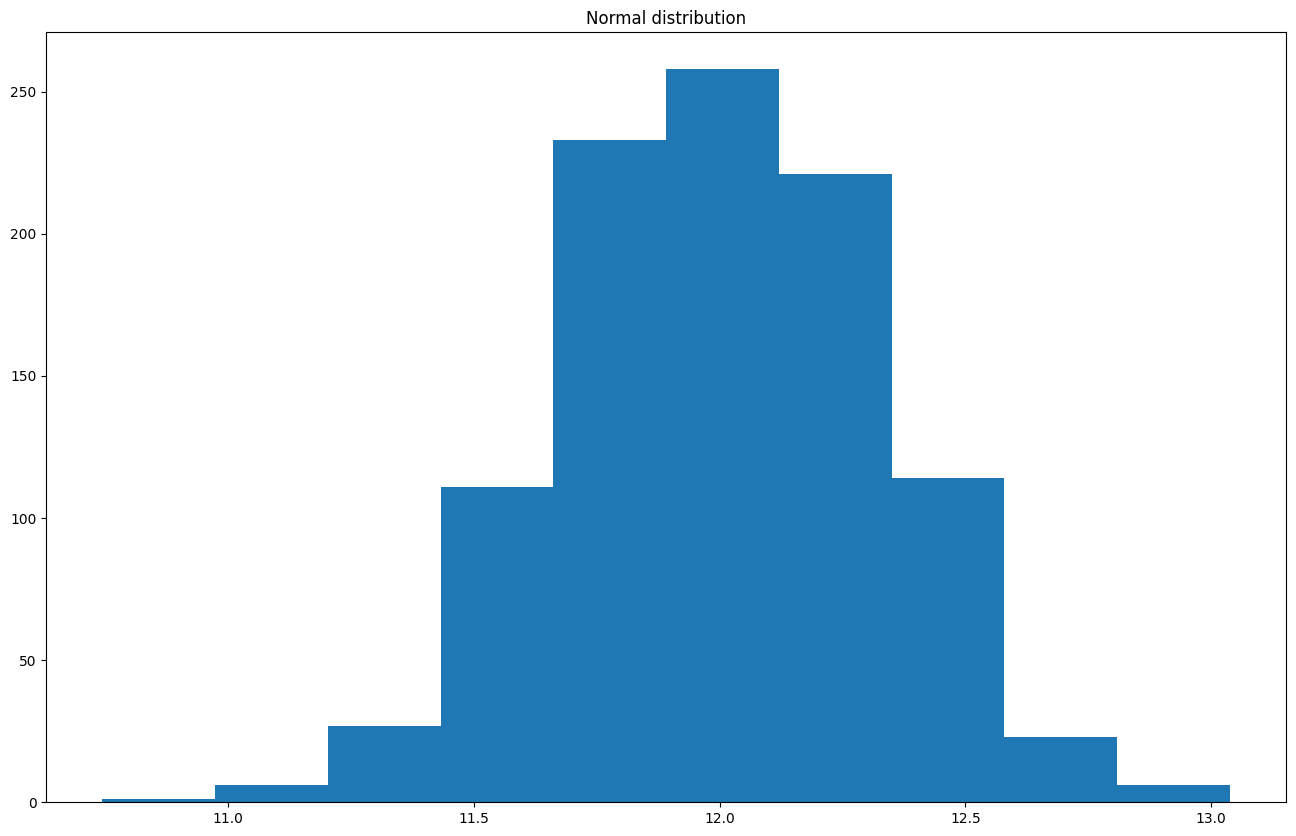

In [6]:
plt.hist(sample_population)
plt.title("Normal distribution");

The more average measurements we take, the smaller the standard deviation.

In [7]:
alpha = 0.05
beta = 0.2

diff = 1
power = 1 - beta
n1 = sp.normal_sample_size_one_tail(
    diff, power, alpha, std_null=1, std_alternative=None
)
n1 = int(np.ceil(n1))
print("at least {} individual measurements are needed".format(n1))

at least 7 individual measurements are needed


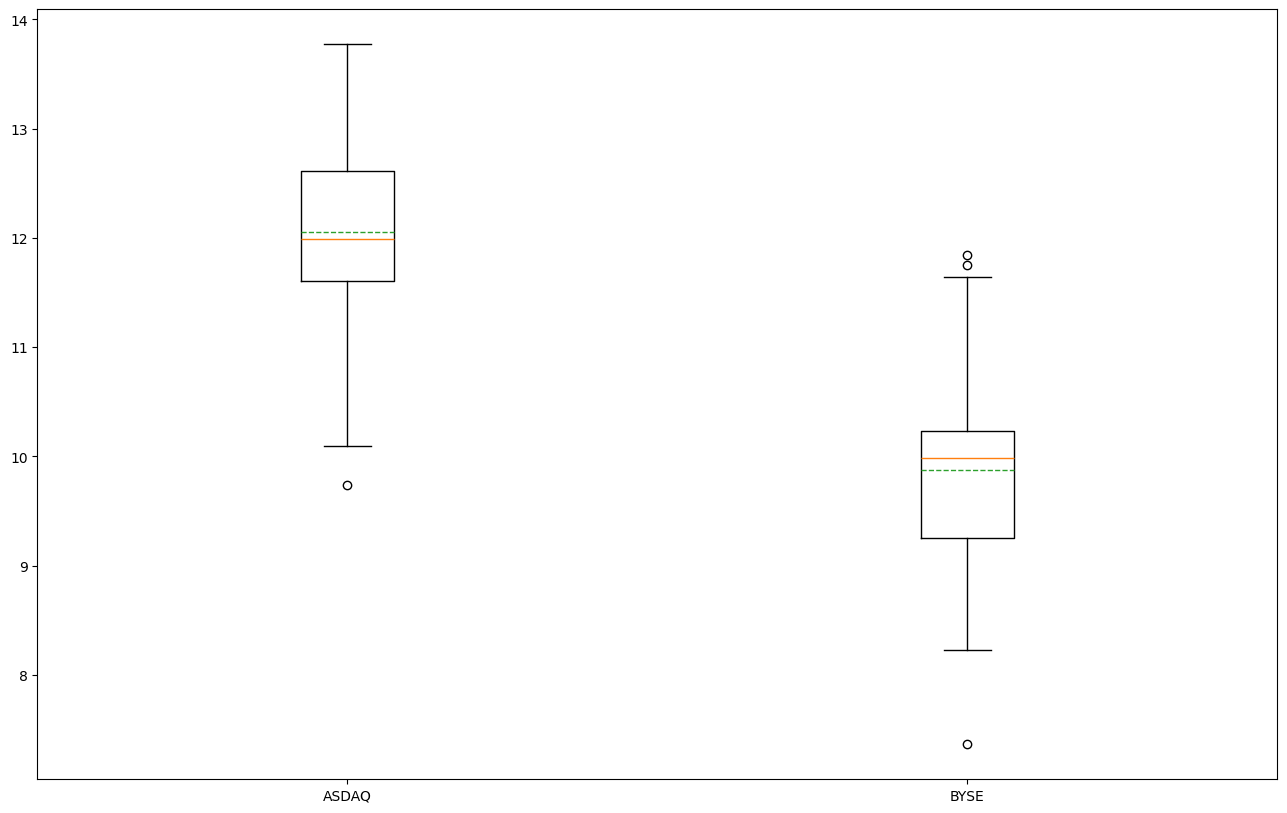

In [8]:
n = 30
asdaq_samples = []
byse_samples = []

# Randomly collecting samples for both ASDAQ and NYSE.
while len(asdaq_samples) < n or len(byse_samples) < n:
    if np.random.random() < 0.5:
        asdaq_samples.append(asdaq.sample())
    else:
        byse_samples.append(byse.sample())

plt.boxplot(
    [asdaq_samples, byse_samples],
    tick_labels=["ASDAQ", "BYSE"],
    showmeans=True,
    meanline=True,
);

In [9]:
sem = st.sem(asdaq_samples)
std = np.std(asdaq_samples)
mean = np.mean(asdaq_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(asdaq_samples))

sem=0.1697 | std=0.9894 | mean=12.0583
35


In [10]:
sem = st.sem(byse_samples)
std = np.std(byse_samples)
mean = np.mean(byse_samples)
print("sem={:.4f} | std={:.4f} | mean={:.4f}".format(sem, std, mean))
print(len(byse_samples))

sem=0.1952 | std=1.0511 | mean=9.8754
30


In [11]:
# NOTE: The position of the X values are important.
# X1 - X2, for smaller alternative.
tstat, pvalue = sm.ztest(
    asdaq_samples,  # Control, A
    byse_samples,  # Treatment, B
    usevar="unequal",
    alternative="larger",
)
tstat, pvalue, pvalue < 0.05, st.norm.sf(tstat)

(8.440166687539547, 1.5844271773879332e-17, True, 1.5844271773879332e-17)

In [12]:
es = 1 / 1
alpha = 0.05
power = 0.8
sm.NormalIndPower().solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

12.365112414769648

In [13]:
sm.zt_ind_solve_power(
    effect_size=es,
    nobs1=None,
    alpha=alpha,
    power=power,
    ratio=1.0,
    alternative="larger",
)

12.365112414769648

If both sample has the same size, the pooled variance is simple the average:

In [14]:
# Mean of group 1, μ_1
mu_1 = np.mean(asdaq_samples)
# Mean of group 2, μ_2
mu_2 = np.mean(byse_samples)
# Sample standard deviation of group 1
s_1 = np.std(asdaq_samples)
# Sample standard deviation of group 2
s_2 = np.std(byse_samples)
# Sampling ratio, κ = n_1 / n_2
kappa = 1

# Type I error rate, α
alpha = 0.05
# Type II error rate, β
beta = 0.2

n_1 = (s_1**2 + s_2**2 / kappa) * (
    (st.norm.ppf(1 - alpha) + st.norm.ppf(1 - beta)) / (mu_1 - mu_2)
) ** 2
n_1

2.7036916741604924

In [15]:
s_1 = np.std(asdaq_samples)
m_1 = np.mean(asdaq_samples)
n_1 = len(asdaq_samples)
s_2 = np.std(byse_samples)
m_2 = np.mean(byse_samples)
n_2 = len(byse_samples)

# If the variance are equal, we can use the pooled variance.
# pooled_var = ((n_1 - 1) * s_1**2 + (n_2 - 1) * s_2**2) / (n_1 - 1 + n_2 - 1)
z = (m_1 - m_2) / np.sqrt(s_1**2 / (n_1 - 1) + s_2**2 / (n_2 - 1))
z

8.440166687539547

In [19]:
p = st.norm.sf(z) 
p, p < alpha

(1.5844271773879332e-17, True)